# 用于跑出所有PnL

In [2]:
# load packages
import pandas as pd
import seaborn as sns
# import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import math
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import utils.prepareDataCSV as prepare
import utils.baselineModels as baseline
import utils.myModel as my
import utils.train as train
import utils.plot as p

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

/cloud/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class C3L(nn.Module):
    def __init__(self, y_len, device):
        super().__init__()
        self.y_len = y_len
        self.device = device

        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception
        self.channel1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.channel2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.channel3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)
        c0 = torch.zeros(1, x.size(0), 64).to(self.device)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x_channel1 = self.channel1(x)
        x_channel2 = self.channel2(x)
        x_channel3 = self.channel3(x)  
        x = torch.cat((x_channel1, x_channel2, x_channel3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

## 账户类

In [5]:
class MyAccount(object):
    def __init__(self, initialCash):
        # 账户中的现金
        self.cash = initialCash
        # 当前持有的股票数量
        self.numberOfStock = 0
    
    def getCash(self):
        return self.cash

    def getNumberOfStock(self):
        return self.numberOfStock
    
    def buy(self,askPrice,ask1Volumu):
    # 全仓买，能买多少买多少，返回askPrice和购买的股票数量
    # 若给定的参数ask1Volumu为-1则表示不做限制
        buyNumber = 0
        if ask1Volumu!=-1:
            buyNumber = min(math.floor(self.cash/askPrice),ask1Volumu)
        else:
            buyNumber = math.floor(self.cash/askPrice)
        self.numberOfStock+=buyNumber
        self.cash-=buyNumber*askPrice
        return askPrice, buyNumber
    
    def sell(self,bidPrice,bid1Volumu):
    # 将手中持有的股票尽可能卖出，返回bidPrice和卖出的股票数量
        sellNumber = 0
        if bid1Volumu!=-1:
            sellNumber = min(bid1Volumu,self.numberOfStock)
        else:
            sellNumber = self.numberOfStock
        self.cash+=bidPrice*sellNumber
        self.numberOfStock -= sellNumber
        return bidPrice, sellNumber

## 基于预测模型结果的交易流程

In [6]:
def getPnL(N, model, tmp_loader, lagedPrice=4,askIndex=2, bidIndex=0):
    cnt = 0
    myAccount = MyAccount(100)
    tradeList = []
    cashList = []
    cashList.append(myAccount.getCash())
    priceOfStock = []
    priceOfStock.append(0)

    for x, y in tmp_loader:
        cnt+=1
        x,y = x.to(device, dtype=torch.float), y.to(device, dtype=torch.int64)
        # dim=2处索引为-1的就是当前时间点的40个维度的特征
        ask1Volumu = int(x[0][0][-1][1].item()*14500)
        bid1Volumu = int(x[0][0][-1][3].item()*14000)
        midPrice = (x[0][0][-1][0].item()+x[0][0][-1][2].item())/2.0
        
        outputs = model(x)
        _, predictions = torch.max(outputs, 1)
        # 每个batch就选择第一个点所在的时间点做决策 并不是每一个样本点处都做决策
        predict_y = predictions[0]
        if predict_y.item()==1:
            # 预测为保持不变,不做动作
            tradeList.append(0)
            cashList.append(myAccount.getCash())
            priceOfStock.append(midPrice*myAccount.getNumberOfStock())
        elif predict_y.item()==2:
            # 预测为上涨趋势，则buy，使用的价格为延迟的价格 不是瞬时的价格
            ask1 = x[lagedPrice][0][-1][askIndex].item()
            askPrice, buyNumber = myAccount.buy(ask1,ask1Volumu)
            # 更新3个list
            tradeList.append(1)
            cashList.append(myAccount.getCash())
            priceOfStock.append(midPrice*myAccount.getNumberOfStock())
        else:
            # 预测为下降趋势，则sell，使用的价格为延迟的价格 不是瞬时的价格
            bid1 = x[lagedPrice][0][-1][bidIndex].item()
            bidPrice, sellNumber = myAccount.sell(bid1, bid1Volumu)

            tradeList.append(-1)
            cashList.append(myAccount.getCash())
            priceOfStock.append(midPrice*myAccount.getNumberOfStock())
        if cnt==N:
            # print(cnt)
            # print(len(cashList))
            bid1 = x[lagedPrice][0][-1][bidIndex].item()
            # 退出市场的时候全部卖出 不做volumu的限制
            bidPrice, sellNumber = myAccount.sell(bid1, -1)

            tradeList.append(-1)
            cashList.append(myAccount.getCash())
            priceOfStock.append(midPrice*myAccount.getNumberOfStock())
            break
    cashArray = np.array(cashList)
    stockPriceArray = np.array(priceOfStock)
    sumValueArray = cashArray+stockPriceArray
    return cashArray, sumValueArray, tradeList

In [7]:
stockIndex=2
train7path = f'../../data/processed/stock{stockIndex}/final_train7_part{stockIndex}.csv'
test7path = f'../../data/processed/stock{stockIndex}/final_test7_part{stockIndex}.csv'
test8path = f'../../data/processed/stock{stockIndex}/final_test8_part{stockIndex}.csv'
test9path = f'../../data/processed/stock{stockIndex}/final_test9_part{stockIndex}.csv'

dec_train, dec_val, dec_test = prepare.splitDataset(0.8,0.8,train7path,test7path,test8path,test9path)
train_loader, val_loader, test_loader = prepare.getDataLoader(dec_train,dec_val,dec_test,k=-20,num_classes=3,T=100,batch_size=7)
model1 = torch.load('./savedModels_rightOrder/stock1_C3L_40_30')

In [13]:
cashArray1, sumValueArray1, tradeList1= getPnL(N = 500, model = model1, tmp_loader =test_loader, lagedPrice=3)

In [14]:
def drawCashChange(sumValueArray):
    fig, axes = plt.subplots()
    axes.plot(range(len(sumValueArray)), sumValueArray)

    title = "cash Change"

    props = {'title': title,
                'xlabel': 'time step',
                'ylabel': 'RMB',
                }
    axes.set(**props)
    plt.show()

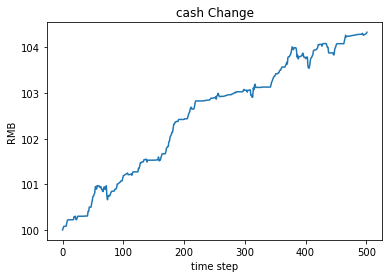

In [15]:
drawCashChange(sumValueArray=sumValueArray1)

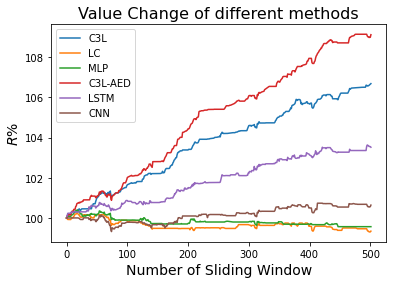

In [8]:
model1 = torch.load('./savedModels_rightOrder/stock1_C3L_40_30')
model2 = torch.load('./savedModels_rightOrder/stock3_LR_40_30')
model3 = torch.load('./savedModels_rightOrder/stock0_MLP_40_30')
model4 = torch.load('./savedModels_rightOrder/stock1_deeplob_40_30')
model5 = torch.load('./savedModels_rightOrder/stock3_LSTM_40_30')
model6 = torch.load('./savedModels_rightOrder/stock2_CNN_40_30')
cashArray1, sumValueArray1, tradeList1= getPnL(500, model = model1, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=0)
cashArray2, sumValueArray2, tradeList2 = getPnL(500, model = model2, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=0)
cashArray3, sumValueArray3, tradeList3= getPnL(500, model = model3, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=2)
cashArray4, sumValueArray4, tradeList4 = getPnL(500, model = model4, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=4)
cashArray5, sumValueArray5, tradeList5 = getPnL(500,  model = model5, tmp_loader = test_loader, lagedPrice=3,askIndex=10,bidIndex=2)
cashArray6, sumValueArray6, tradeList6 = getPnL(500, model = model6, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=4)

fig, axes = plt.subplots()
axes.plot(range(len(cashArray1)), sumValueArray1, label="C3L")
axes.plot(range(len(cashArray2)), sumValueArray2, label="LC")
axes.plot(range(len(cashArray3)), sumValueArray3, label="MLP")
axes.plot(range(len(cashArray4)), sumValueArray4, label="C3L-AED")
axes.plot(range(len(cashArray5)), sumValueArray5, label="LSTM")
axes.plot(range(len(cashArray6)), sumValueArray6, label="CNN")

axes.set_title("Value Change of different methods", fontsize=16)
axes.set_xlabel("Number of Sliding Window",fontsize=14)
axes.set_ylabel("$R$%",fontsize=14)
axes.legend()

plt.show()

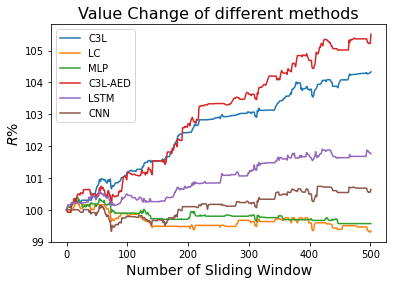

In [9]:
cashArray1, sumValueArray1, tradeList1= getPnL(500, model = model1, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=0)
cashArray2, sumValueArray2, tradeList2 = getPnL(500, model = model2, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=0)
cashArray3, sumValueArray3, tradeList3= getPnL(500, model = model3, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=2)
cashArray4, sumValueArray4, tradeList4 = getPnL(500, model = model4, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=12)
cashArray5, sumValueArray5, tradeList5 = getPnL(500,  model = model5, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=2)
cashArray6, sumValueArray6, tradeList6 = getPnL(500, model = model6, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=4)

fig, axes = plt.subplots()
axes.plot(range(len(cashArray1)), sumValueArray1, label="C3L")
axes.plot(range(len(cashArray2)), sumValueArray2, label="LC")
axes.plot(range(len(cashArray3)), sumValueArray3, label="MLP")
axes.plot(range(len(cashArray4)), sumValueArray4, label="C3L-AED")
axes.plot(range(len(cashArray5)), sumValueArray5, label="LSTM")
axes.plot(range(len(cashArray6)), sumValueArray6, label="CNN")

axes.set_title("Value Change of different methods", fontsize=16)
axes.set_xlabel("Number of Sliding Window",fontsize=14)
axes.set_ylabel("$R$%",fontsize=14)
axes.legend()

plt.show()

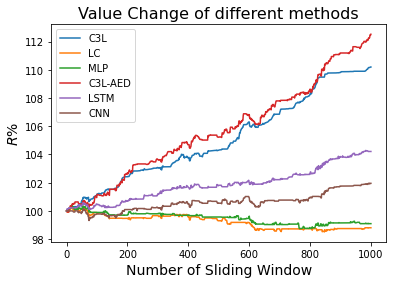

In [10]:
cashArray1, sumValueArray1, tradeList1= getPnL(1000, model = model1, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=0)
cashArray2, sumValueArray2, tradeList2 = getPnL(1000, model = model2, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=0)
cashArray3, sumValueArray3, tradeList3= getPnL(1000, model = model3, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=2)
cashArray4, sumValueArray4, tradeList4 = getPnL(1000, model = model4, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=12)
cashArray5, sumValueArray5, tradeList5 = getPnL(1000,  model = model5, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=2)
cashArray6, sumValueArray6, tradeList6 = getPnL(1000, model = model6, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=4)

fig, axes = plt.subplots()
axes.plot(range(len(cashArray1)), sumValueArray1, label="C3L")
axes.plot(range(len(cashArray2)), sumValueArray2, label="LC")
axes.plot(range(len(cashArray3)), sumValueArray3, label="MLP")
axes.plot(range(len(cashArray4)), sumValueArray4, label="C3L-AED")
axes.plot(range(len(cashArray5)), sumValueArray5, label="LSTM")
axes.plot(range(len(cashArray6)), sumValueArray6, label="CNN")

axes.set_title("Value Change of different methods", fontsize=16)
axes.set_xlabel("Number of Sliding Window",fontsize=14)
axes.set_ylabel("$R$%",fontsize=14)
axes.legend()

plt.show()

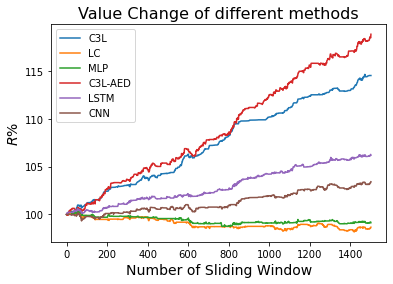

In [11]:
cashArray1, sumValueArray1, tradeList1= getPnL(1500, model = model1, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=0)
cashArray2, sumValueArray2, tradeList2 = getPnL(1500, model = model2, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=0)
cashArray3, sumValueArray3, tradeList3= getPnL(1500, model = model3, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=2)
cashArray4, sumValueArray4, tradeList4 = getPnL(1500, model = model4, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=12)
cashArray5, sumValueArray5, tradeList5 = getPnL(1500,  model = model5, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=2)
cashArray6, sumValueArray6, tradeList6 = getPnL(1500, model = model6, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=4)

fig, axes = plt.subplots()
axes.plot(range(len(cashArray1)), sumValueArray1, label="C3L")
axes.plot(range(len(cashArray2)), sumValueArray2, label="LC")
axes.plot(range(len(cashArray3)), sumValueArray3, label="MLP")
axes.plot(range(len(cashArray4)), sumValueArray4, label="C3L-AED")
axes.plot(range(len(cashArray5)), sumValueArray5, label="LSTM")
axes.plot(range(len(cashArray6)), sumValueArray6, label="CNN")

axes.set_title("Value Change of different methods", fontsize=16)
axes.set_xlabel("Number of Sliding Window",fontsize=14)
axes.set_ylabel("$R$%",fontsize=14)
axes.legend()

plt.show()

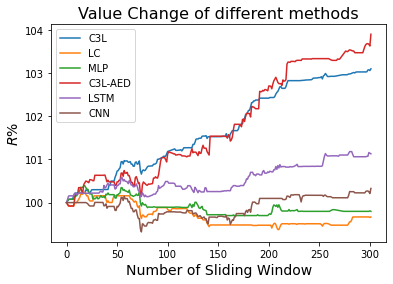

In [12]:
cashArray1, sumValueArray1, tradeList1= getPnL(300, model = model1, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=0)
cashArray2, sumValueArray2, tradeList2 = getPnL(300, model = model2, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=0)
cashArray3, sumValueArray3, tradeList3= getPnL(300, model = model3, tmp_loader = test_loader, lagedPrice=3,askIndex=2,bidIndex=2)
cashArray4, sumValueArray4, tradeList4 = getPnL(300, model = model4, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=12)
cashArray5, sumValueArray5, tradeList5 = getPnL(300,  model = model5, tmp_loader = test_loader, lagedPrice=3,askIndex=6,bidIndex=2)
cashArray6, sumValueArray6, tradeList6 = getPnL(300, model = model6, tmp_loader = test_loader, lagedPrice=3,askIndex=0,bidIndex=4)

fig, axes = plt.subplots()
axes.plot(range(len(cashArray1)), sumValueArray1, label="C3L")
axes.plot(range(len(cashArray2)), sumValueArray2, label="LC")
axes.plot(range(len(cashArray3)), sumValueArray3, label="MLP")
axes.plot(range(len(cashArray4)), sumValueArray4, label="C3L-AED")
axes.plot(range(len(cashArray5)), sumValueArray5, label="LSTM")
axes.plot(range(len(cashArray6)), sumValueArray6, label="CNN")

axes.set_title("Value Change of different methods", fontsize=16)
axes.set_xlabel("Number of Sliding Window",fontsize=14)
axes.set_ylabel("$R$%",fontsize=14)
axes.legend()

plt.show()

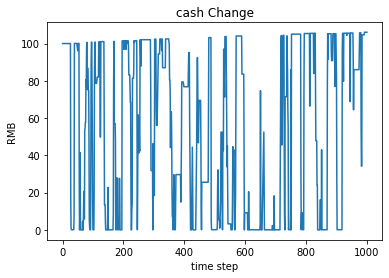

In [20]:
drawCashChange(cashArray1)

In [16]:
def getActionPnL(cashArray, sumValueArray):
    actionPnLArray=[]
    N=len(cashArray)
    for index in range(N-1):
        pastCash = cashArray[index]
        nowCash = cashArray[index+1]
        if pastCash!=nowCash:
            pastSumValue = sumValueArray[index]
            nowSumValue = sumValueArray[index+1]
            actionPnL=(nowSumValue-pastSumValue)/pastSumValue
            actionPnLArray.append(actionPnL)
    return actionPnLArray

In [38]:
def getUpDown(array):
    up, down= [],[]
    for x in array:
        if x>0:
            up.append(x)
        else:
            down.append(x)
    return up,down

In [37]:
C3LActionPnLArray =  getActionPnL(cashArray1,sumValueArray1)
LCActionPnLArray =  getActionPnL(cashArray2,sumValueArray2)
MLPActionPnLArray =  getActionPnL(cashArray3,sumValueArray3)
FinalActionPnLArray =  getActionPnL(cashArray4,sumValueArray4)
LSTMActionPnLArray =  getActionPnL(cashArray5,sumValueArray5)
CNNActionPnLArray =  getActionPnL(cashArray6,sumValueArray6)

In [39]:
C3Lup,C3Ldown = getUpDown(C3LActionPnLArray)
LCup,LCdown = getUpDown(LCActionPnLArray)
MLPup,MLPdown = getUpDown(MLPActionPnLArray)
Finalup,Finaldown = getUpDown(FinalActionPnLArray)
LSTMup,LSTMdown = getUpDown(LSTMActionPnLArray)
CNNup,CNNdown = getUpDown(CNNActionPnLArray)

In [40]:
upList,downList = [len(C3Lup),len(Finalup),len(LCup),len(MLPup),len(CNNup),len(LSTMup)],[len(C3Ldown),len(Finaldown),len(LCdown),len(MLPdown),len(CNNdown),len(LSTMdown)]
labels = ['C3L','C3L-AED','LC','MLP','CNN','LSTM']

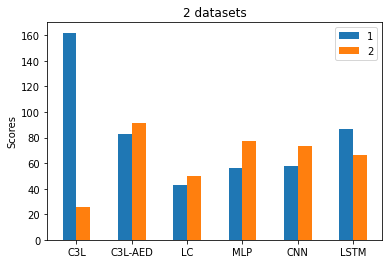

In [42]:
fig,axes = plt.subplots()
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
axes.bar(x - width/2, upList, width, label='1')
axes.bar(x + width/2, downList, width, label='2')
axes.set_ylabel('Scores')
axes.set_title('2 datasets')
# x轴刻度标签位置不进行计算
axes.set_xticks(x, labels=labels)
plt.legend()
plt.show()